In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [3]:
YEAR_START = 1986
YEAR_TRAIN_END = 2018

YEAR_VALIDATE_START = 2019
YEAR_VALIDATE_END = 2020

NUM_YEARS_TO_PREDICT = 12

NUM_YEARS_TO_VALIDATE = YEAR_VALIDATE_END - YEAR_TRAIN_END
NUM_YEARS_FORCASTED = NUM_YEARS_TO_PREDICT + NUM_YEARS_TO_VALIDATE

In [4]:
def read_deaths_csv():
    # Read data
    data = pd.read_csv('deaths.csv')
    data = data[['Year', 'Age', 'Deaths']]

    # Remove rows with Age tot and unk
    data = data[data['Age'] != 'TOT']
    data = data[data['Age'] != 'UNK']

    # Convert ages from string to float
    data['Age'] = data['Age'].astype(float)

    X = 100 # Ages
    T = YEAR_VALIDATE_END - YEAR_START + 1 # Years
    # Create a mortality matrix
    mortality_matrix = np.zeros((T, X))
    for i in range(T):
        for j in range(X):
            mortality_matrix[i, j] = data[(data['Year'] == 1986 + i) & (data['Age'] == j)]['Deaths'].values[0]

    # Check the nan or zero values
    eps = 1e-6
    for i in range(T):
        for j in range(X):
            if mortality_matrix[i, j] == 0:
                mortality_matrix[i, j] = eps # Replace zero values with a small value so that the log can be calculated
                print('Zero value at year', i + YEAR_START, 'age', j)
 
    # Remove years that are not in the training set
    train_matrix = mortality_matrix[:YEAR_TRAIN_END - YEAR_START + 1, :]

    return mortality_matrix, train_matrix

In [14]:
def read_death_rate_csv(has_110_plus=False):
    data = pd.read_csv('death_rate.csv', sep='\s+')
    data = data[['Year', 'Age', 'Total']]

    if has_110_plus:
        X = 24
    else:
        X = 23
    T = YEAR_VALIDATE_END - YEAR_START + 1
    eps = 1e-6
    mortality_matrix = np.zeros((T, X))
    for i in range(T):
        for j in range(X):
            year_data = data[data['Year'] == 1986 + i]
            age_data = year_data.iloc[j]
            death_rate = age_data['Total']
            mortality_matrix[i, j] = eps if death_rate == '.' or float(death_rate) == 0.0 else float(death_rate)

    # Exclude the last age gorup
    #mortality_matrix = mortality_matrix[:, :mortality_matrix.shape[1] - 1]
    train_matrix = mortality_matrix[:YEAR_TRAIN_END - YEAR_START + 1, :]

    return mortality_matrix, train_matrix

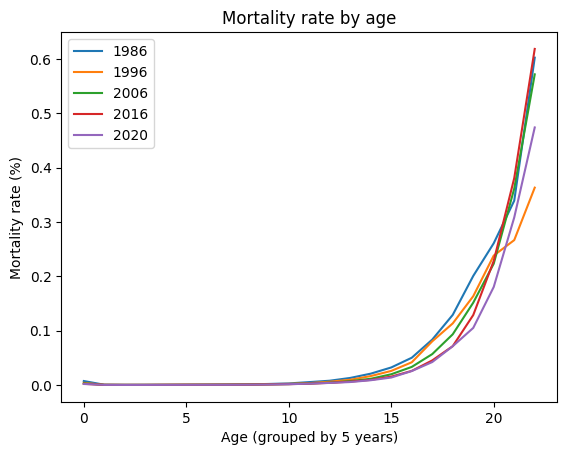

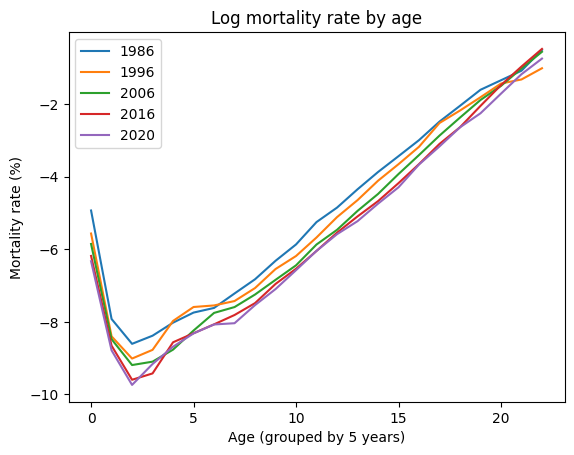

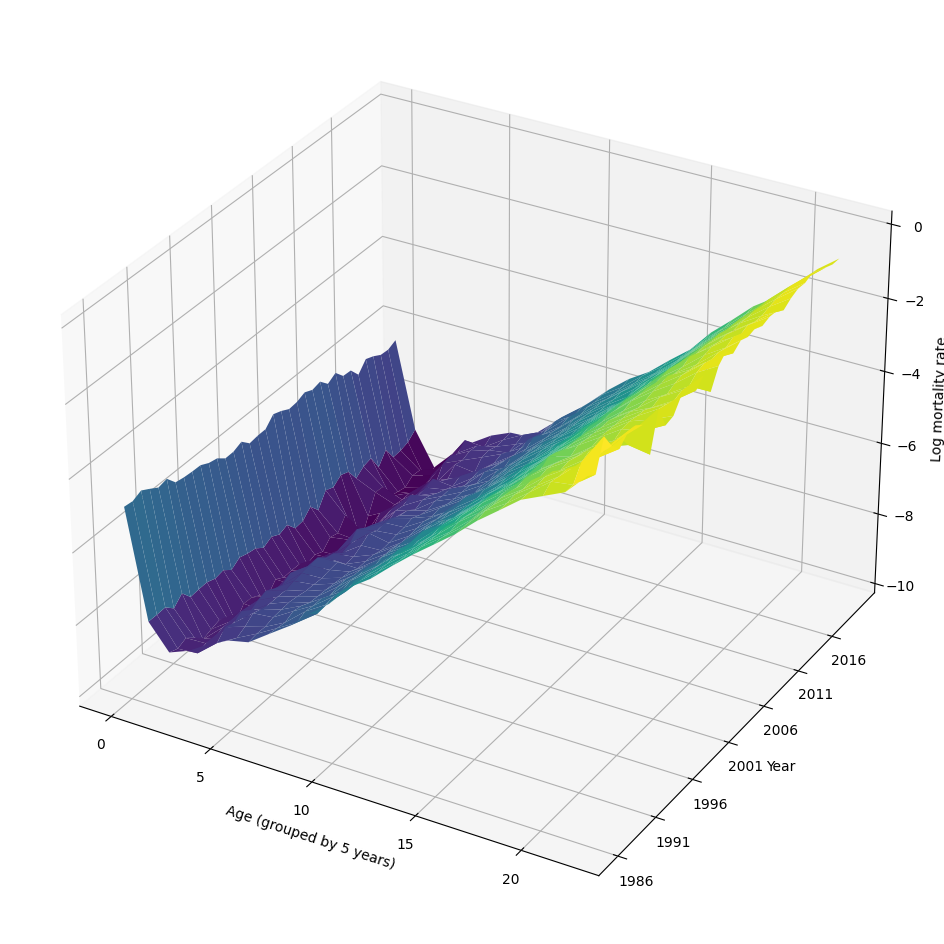

In [40]:
def plot_mortality(mortality_matrix, year_start, years=[1986, 2016, 2018]):
    plt.clf()
    for year in years:
        plt.plot(mortality_matrix[year - year_start], label=str(year))

    plt.title('Mortality rate by age')
    plt.xlabel('Age (grouped by 5 years)')
    plt.ylabel('Mortality rate (%)')
    plt.legend()
    plt.show()

def plot_mortality_log(mortality_matrix, year_start, years=[1986, 2016, 2018]):
    plt.clf()
    for year in years:
        plt.plot(np.log(mortality_matrix[year - year_start]), label=str(year))

    plt.title('Log mortality rate by age')
    plt.xlabel('Age (grouped by 5 years)')
    plt.ylabel('Mortality rate (%)')
    plt.legend()
    plt.show()


def plot_mortality_rate_3d_log(mortality_matrix, year_start):
    mortality_matrix = np.log(mortality_matrix)
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    X = np.arange(mortality_matrix.shape[1])
    Y = np.arange(mortality_matrix.shape[0])
    X, Y = np.meshgrid(X, Y)
    Z = mortality_matrix[Y, X]
    ax.plot_surface(X, Y, Z, cmap='viridis')
    plt.xlabel('Age (grouped by 5 years)')
    # tick every 5 yearsm
    plt.yticks(np.arange(0, mortality_matrix.shape[0], 5))
    y_labels = np.arange(year_start, year_start + mortality_matrix.shape[0], 5)
    ax.set_yticklabels(y_labels)
    ax.set_ylabel('Year')
    ax.set_zlabel('Log mortality rate')
    plt.show()

mortality_matrix, train_matrix = read_death_rate_csv()

plot_mortality(mortality_matrix, YEAR_START, years=[1986, 1996, 2006, 2016, 2020])
plot_mortality_log(mortality_matrix, YEAR_START, years=[1986, 1996, 2006, 2016, 2020])
plot_mortality_rate_3d_log(mortality_matrix, YEAR_START)

In [41]:
def lee_carter(M, n, ARIMA_order=(2, 1, 2)):
    ''' Lee-Carter model for population forecasting
    Rows are years, columns are age groups
    https://en.wikipedia.org/wiki/Lee%E2%80%93Carter_model

    Args:
        M: matrix of population
        n: number of years to forecast
    '''
    log_M = np.log(M) # (T, X)

    # a_x = \frac{1}{T} \sum_{t=1}^{T} ln(M_{x,t})
    T = log_M.shape[0]
    ax = log_M.sum(axis=0) / T # （X, ）

    # A_{x,t} = ln(M_{x,t}) - a_x
    A = log_M - ax[np.newaxis, :] # （T, X）

    # SVD
    U, s, V = np.linalg.svd(A)
    s1 = s[0]

    # kt = (u11, u21, ..., ut1)
    kt = np.matrix.transpose(U)[0] # (T, )

    # bx = (v11, v12, ..., v1x)
    bx = V[0] # (X, )

    def arima_fit(kt, n):
        e = kt[-1] - kt[0]
        forc = np.zeros((n, ))
        for i in range(n):
            forc[i] = kt[-1] + e * (i+1) / T
        return forc

    # k' = ARIMA(kt, n)
    # arima = ARIMA(kt, order=ARIMA_order)
    # model = arima.fit()
    # k_ = model.forecast(steps=n) # (n, )
    k_ = arima_fit(kt, n)
    print(k_)
    k_ = np.concatenate([kt, k_]) # (T+n, )
 
    # M' = exp(ax + s1k'bx)
    M_ = np.zeros((T+n, M.shape[1]))
    for i in range(T+n):
        M_[i , :] = np.exp(ax + s1 * k_[i] * bx)  # (X, n)

    return M_, ax, kt, bx, s1

In [42]:
mortality_matrix, train_matrix = read_death_rate_csv()
M, ax, kt, bx, s1 = lee_carter(train_matrix, NUM_YEARS_TO_PREDICT, ARIMA_order=(0, 1, 0))

[0.28881036 0.30574614 0.32268193 0.33961772 0.35655351 0.3734893
 0.39042508 0.40736087 0.42429666 0.44123245 0.45816824 0.47510403]


In [43]:
def plot_ax(ax):
    plt.plot(range(ax.shape[0]-1), ax[:-1])
    plt.xlabel('Age')
    plt.ylabel('a_x')
    plt.title('a_x')
    plt.show()

def plot_kt(kt, year_start):
    plt.plot([i + year_start for i in range(kt.shape[0])], kt)
    plt.xlabel('Year')
    plt.ylabel('k_t')
    plt.title('k_t')
    plt.show()

def plot_bx(bx):
    plt.plot(range(bx.shape[0] - 1), bx[:-1])
    plt.xlabel('Age')
    plt.ylabel('b_x')
    plt.title('b_x')
    plt.show()

def plot_year(prediction, truth, year_start, year):
    X = prediction.shape[1]-1
    if year - year_start < truth.shape[0]:
        plt.plot(range(X), truth[year - year_start, :-1], label='True')
    plt.plot(range(X), prediction[year - year_start, :-1], label='Forecasted')
    plt.xlabel('Age (Grouped)')
    plt.ylabel('Deaths')
    plt.title('Death prediction at year {}'.format(year)) # 中文会出乱码
    plt.legend()
    plt.show()

def plot_year_log(prediction, truth, year_start, year):
    X = prediction.shape[1]-1
    if year - year_start < truth.shape[0]:
        plt.plot(range(X), np.log(truth[year - year_start, :-1]), label='True')
    plt.plot(range(X), np.log(prediction[year - year_start, :-1]), label='Forecasted')
    plt.xlabel('Age (Grouped)')
    plt.ylabel('Deaths')
    plt.title('Log death prediction at year {}'.format(year))
    plt.legend()
    plt.show()

def plot_age(prediction, truth, age, year_start, output_dir='output'):
    '''
    Plot the prediction and truth for a specific age
    
    Args:
        prediction: matrix of prediction
        truth: matrix of truth
        age: the age to plot (grouped)
        output_dir: the output directory
    '''
    # Clear the plot
    plt.clf()
    plt.plot([x + year_start for x in range(truth.shape[0])], truth[:, age], label='True')
    plt.plot([x + year_start for x in range(prediction.shape[0])], prediction[:, age], label='Forecasted')
    plt.xlabel('Year')
    plt.ylabel('Deaths')
    plt.title('Death prediction at age {} (grouped)'.format(age))
    plt.legend()
    plt.show()

def plot_error_3d(prediction, truth, year_start):
    plt.clf()
    X = truth.shape[1] - 1
    Y = truth.shape[0]
    Z = np.zeros((Y, X))
    for i in range(Y):
        for j in range(X):
            Z[i, j] = (truth[i, j] - prediction[i, j])/truth[i, j]
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    X = np.arange(X)
    Y = np.arange(Y)
    X, Y = np.meshgrid(X, Y)
    Z = Z[Y, X]
    ax.plot_surface(X, Y, Z, cmap='viridis')
    plt.xlabel('Age (grouped by 5 years)')
    # tick every 5 yearsm
    plt.yticks(np.arange(0, Y.shape[0], 5))
    y_labels = np.arange(year_start, year_start + Y.shape[0], 5)
    ax.set_yticklabels(y_labels)
    ax.set_ylabel('Year')
    ax.set_zlabel('Error')
    plt.show()

def rmse(prediction, truth):
    N = truth.shape[0]
    return np.sqrt(np.sum((prediction - truth) ** 2) / N)

def mape(prediction, truth):
    N = truth.shape[0]
    return np.sum(np.abs(prediction - truth) / truth) / N


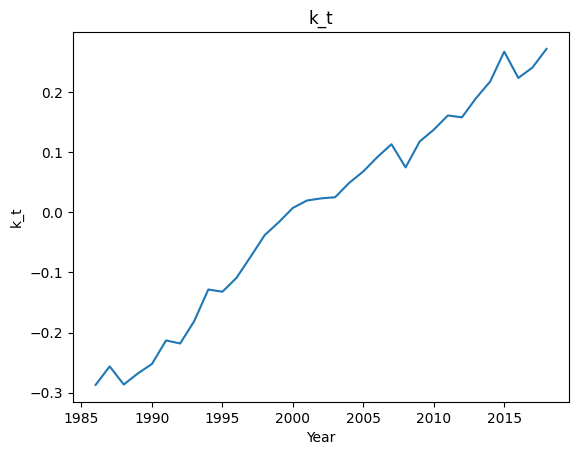

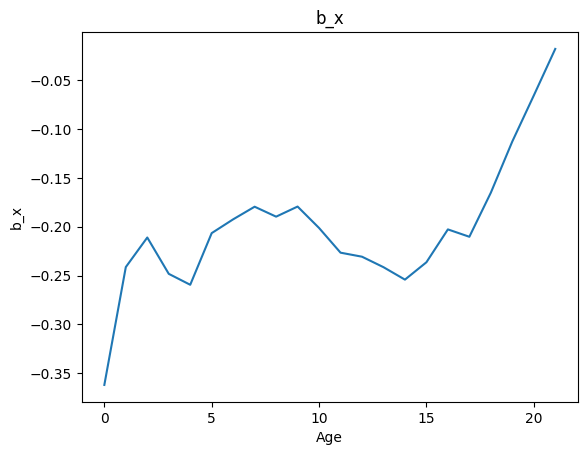

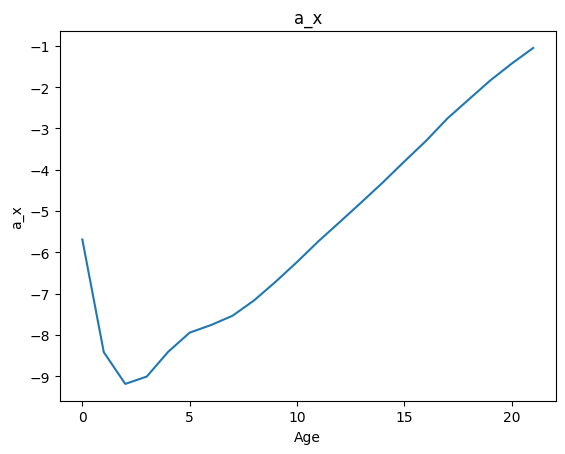

-4.492056797043397


In [44]:
plot_kt(kt, YEAR_START)
plot_bx(bx)
plot_ax(ax)
print(np.sum(bx))

In [45]:
mortality_matrix[YEAR_TRAIN_END+1-YEAR_START].shape

(23,)

In [46]:
# 201'9
print('RMSE:', rmse(M[YEAR_TRAIN_END+1-YEAR_START], mortality_matrix[YEAR_TRAIN_END+1-YEAR_START]))
print('MAPE:', mape(M[YEAR_TRAIN_END+1-YEAR_START], mortality_matrix[YEAR_TRAIN_END+1-YEAR_START]))

RMSE: 0.007825838430915132
MAPE: 0.10972318442321007


In [47]:

print('RMSE:', rmse(M[YEAR_TRAIN_END+2-YEAR_START], mortality_matrix[YEAR_TRAIN_END+2-YEAR_START]))
print('MAPE:', mape(M[YEAR_TRAIN_END+2-YEAR_START], mortality_matrix[YEAR_TRAIN_END+2-YEAR_START]))

RMSE: 0.009995798701694108
MAPE: 0.08880391515376038


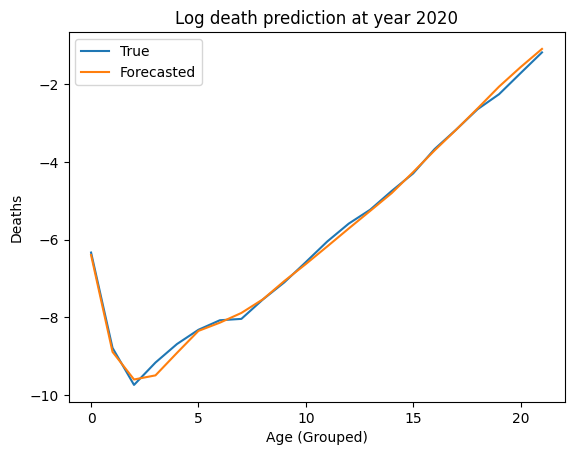

In [56]:
plot_year_log(M, mortality_matrix, YEAR_START, YEAR_TRAIN_END+2)

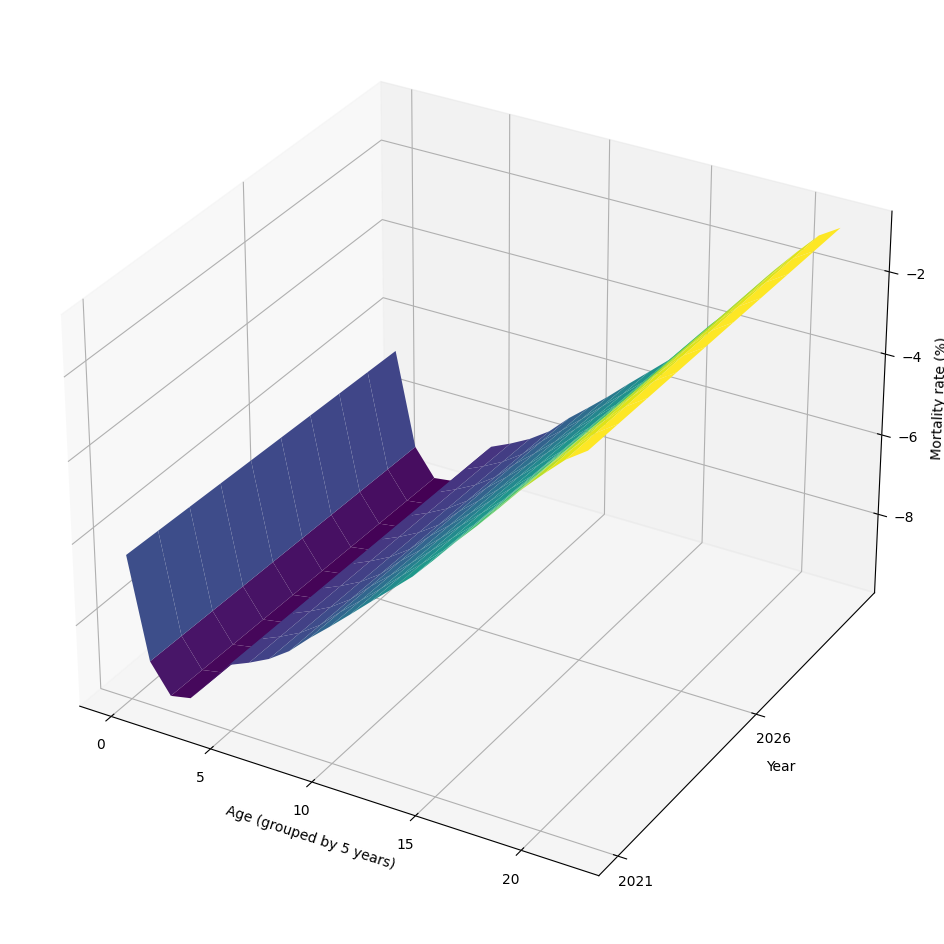

In [36]:
plot_mortality_rate_3d_log(M[2021-1986:,:], 2021)

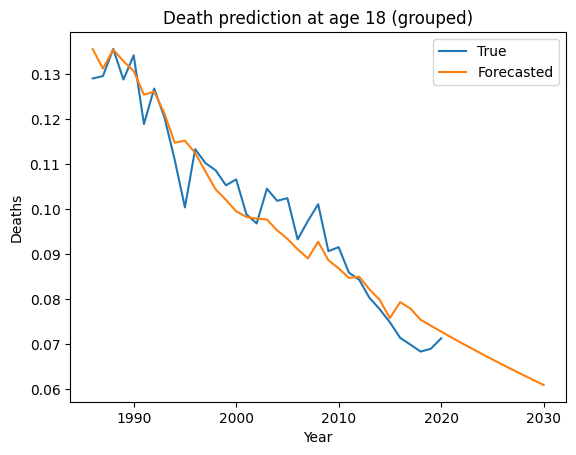

<Figure size 640x480 with 0 Axes>

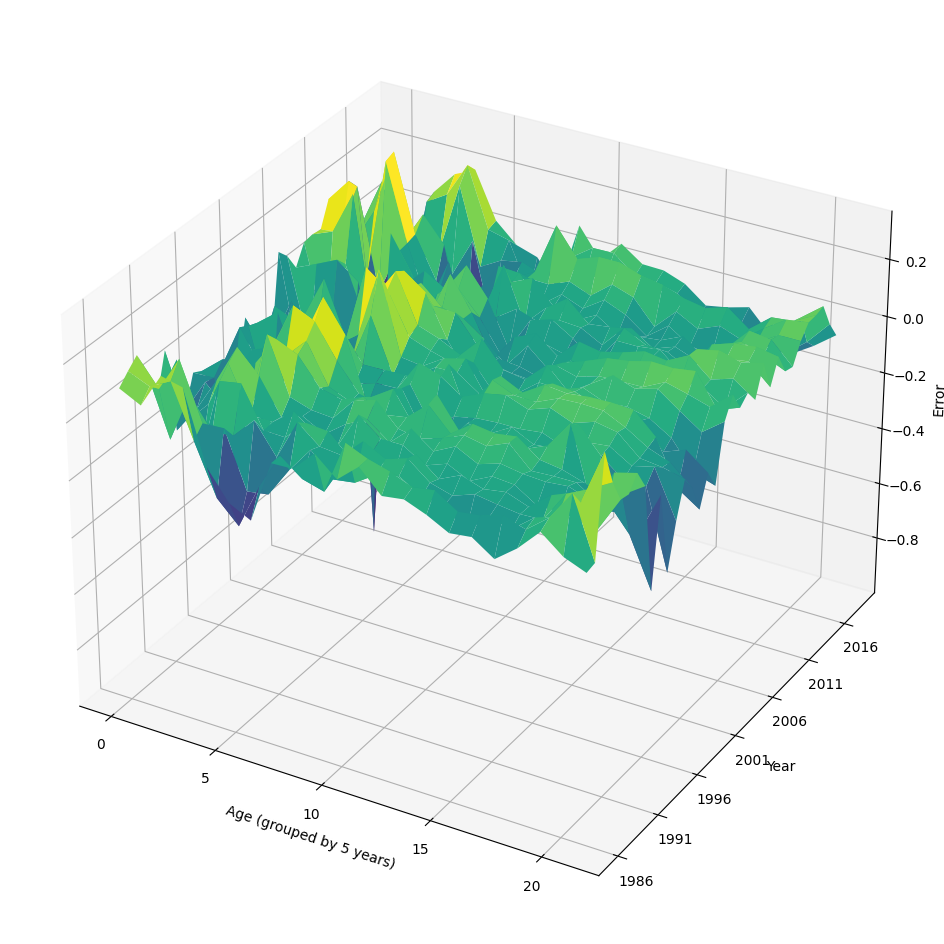

In [53]:
plot_age(M, mortality_matrix, 18, YEAR_START)
plot_error_3d(M, train_matrix, YEAR_START)